In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as Fn
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import os
import pandas as pd
from diffusers import AutoencoderDC
import gc
from torchvision import transforms
import wandb
import kornia
from torchvision.models import vgg16
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import random
from einops import rearrange
from transformers import CLIPTokenizer, CLIPTextModel
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [3]:
# wandb.init(
#     project="HYBRID-T2I",  
#     name="transformer-Decoder",    
#     id="1gzdn6z4",  
#     resume="allow",
# )

In [4]:
class VectorQuantizeImage(nn.Module):
    def __init__(self, codeBookDim = 64, embeddingDim = 32, decay = 0.99, eps = 1e-5):
        super().__init__()

        self.codeBookDim = codeBookDim
        self.embeddingDim = embeddingDim
        self.decay = decay
        self.eps = eps
        self.dead_codeBook_threshold = codeBookDim * 0.6

        self.codebook = nn.Embedding(codeBookDim, embeddingDim)
        nn.init.xavier_uniform_(self.codebook.weight.data)

        self.register_buffer('ema_Count', torch.zeros(codeBookDim))
        self.register_buffer('ema_Weight', self.codebook.weight.data.clone())

    def forward(self, x):
        x_reshaped = x.view(-1, self.embeddingDim)

        distance = (torch.sum(x_reshaped**2, dim=1, keepdim=True) 
                    + torch.sum(self.codebook.weight**2, dim=1)
                    - 2 * torch.matmul(x_reshaped, self.codebook.weight.t()))
        
        encoding_indices = torch.argmin(distance, dim=1) 
        encodings = Fn.one_hot(encoding_indices, self.codeBookDim).type(x_reshaped.dtype)
        quantized = torch.matmul(encodings, self.codebook.weight)

        if self.training:
            self.ema_Count = self.decay * self.ema_Count + (1 - self.decay) * torch.sum(encodings, 0)
            
            x_reshaped_sum = torch.matmul(encodings.t(), x_reshaped.detach())
            self.ema_Weight = self.decay * self.ema_Weight + (1 - self.decay) * x_reshaped_sum
            
            n = torch.clamp(self.ema_Count, min=self.eps)
            updated_embeddings = self.ema_Weight / n.unsqueeze(1)
            self.codebook.weight.data.copy_(updated_embeddings)

        
        avg_probs = torch.mean(encodings, dim=0)
        log_encoding_sum = -torch.sum(avg_probs * torch.log(avg_probs + self.eps))
        perplexity = torch.exp(log_encoding_sum)

        entropy = log_encoding_sum
        # normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device))
        normalized_entropy = entropy / torch.log(torch.tensor(self.codeBookDim, device=x.device, dtype=x.dtype))

        diversity_loss = 1.0 - normalized_entropy

        return quantized, encoding_indices, perplexity, diversity_loss
    


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = self.relu(out)
        return out


class VecQVAE(nn.Module):
    def __init__(self, inChannels = 1, hiddenDim = 32, codeBookdim = 128, embedDim = 128):
        super().__init__()
        self.inChannels = inChannels
        self.hiddenDim = hiddenDim
        self.codeBookdim = codeBookdim
        self.embedDim = embedDim

        self.encoder = nn.Sequential(
            nn.Conv2d(inChannels, hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(hiddenDim),
            ResidualBlock(hiddenDim),
            
            nn.Conv2d(hiddenDim, 2 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(2 * hiddenDim),
            ResidualBlock(2 * hiddenDim),
            
            nn.Conv2d(2 * hiddenDim, 4 * hiddenDim, 4, 2, 1),
            nn.BatchNorm2d(4 * hiddenDim),
            nn.ReLU(inplace=True),
            ResidualBlock(4 * hiddenDim),
            ResidualBlock(4 * hiddenDim),
            
            nn.Conv2d(4 * hiddenDim, embedDim, 1),
        )

        self.vector_quantize = VectorQuantizeImage(codeBookDim=codeBookdim,embeddingDim=embedDim)

        self.decoder = nn.Sequential(
            nn.Conv2d(embedDim, 4 * hiddenDim, 3, padding=1),
            nn.BatchNorm2d(4 * hiddenDim),
            nn.ReLU(inplace=True),
        
            ResidualBlock(4 * hiddenDim),
            ResidualBlock(4 * hiddenDim),
        
            nn.ConvTranspose2d(
                4 * hiddenDim, 2 * hiddenDim,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(2 * hiddenDim),
            nn.ReLU(inplace=True),
        
            ResidualBlock(2 * hiddenDim),
            ResidualBlock(2 * hiddenDim),
        
            nn.ConvTranspose2d(
                2 * hiddenDim, hiddenDim,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
        
            ResidualBlock(hiddenDim),
            ResidualBlock(hiddenDim),
        
            nn.ConvTranspose2d(
                hiddenDim, hiddenDim,
                kernel_size=4, stride=2, padding=1
            ),
            nn.BatchNorm2d(hiddenDim),
            nn.ReLU(inplace=True),
        
            nn.Conv2d(hiddenDim, inChannels, kernel_size=3, padding=1),
            # nn.Sigmoid()
            nn.Tanh()
        )

    
    def encoderBlock(self, x, noise_std = 0.15):
        if self.training:
            encodedOut = self.encoder(x)
            encodedOut = encodedOut + torch.randn_like(encodedOut) * noise_std
        else:
            encodedOut = self.encoder(x)

        return encodedOut

    def decoderBlock(self, quantized_vector):
        decodedOut = self.decoder(quantized_vector)
        return decodedOut

    def forward(self, x):
        batch_size, inChannels, height, width = x.shape
        encodedOut = self.encoderBlock(x)
        batch_size, encoded_channel, encoded_height, encoded_width = encodedOut.shape
        
        # print(f"Encoded Shape: {encodedOut.shape}")

        
        vectorize_input = rearrange(encodedOut, 'b c h w -> (b h w) c')
        quantized_vectors, encoding_indices, perplexity, diversity_loss  = self.vector_quantize(vectorize_input)
        codebook_loss = Fn.mse_loss(vectorize_input.detach(), quantized_vectors)
        commitment_loss = Fn.mse_loss(vectorize_input, quantized_vectors.detach())

        quantized_vectors = vectorize_input + (quantized_vectors - vectorize_input).detach()
        # print(f"CodeBook Loss: {codebook_loss} , Commitment Loss: {commitment_loss}")
        # print(f"Quantized SHape: {quantized_vectors.shape}")

        decoder_input = rearrange(quantized_vectors, '(b h w) d -> b d h w', d = encoded_channel, h = encoded_height, w = encoded_width)
        # print(f"Decoded Input SHape: {decoder_input.shape}")
        decodedOut = self.decoderBlock(decoder_input)

        
        return decoder_input, decodedOut, codebook_loss, commitment_loss, encoding_indices, perplexity, diversity_loss



In [5]:
def rotFrequency(headDim, seqLen, theta=10000.0):
    assert headDim % 2 == 0
    inv_freq = 1.0 / (
        theta ** (torch.arange(0, headDim, 2).float() / headDim)
    )
    positions = torch.arange(seqLen).float()
    freqs = torch.outer(positions, inv_freq)

    return freqs

# freq = rotFrequency(512, 4096)
# freq.shape


def ropEQK(x, freqs):
    freqs = freqs.to(device=x.device, dtype=x.dtype)
    cos = freqs.cos()[None, :, None, :]
    sin = freqs.sin()[None, :, None, :]

    evenVals = x[..., 0::2]
    oddVals  = x[..., 1::2]
    evenVals.to(device)
    oddVals.to(device)
    

    rotated = torch.cat(
        [
            evenVals * cos - oddVals * sin,
            evenVals * sin + oddVals * cos
        ],
        dim=-1
    )

    return rotated

# class RotatedQK(nn.Module):
    


# q = torch.randn(1, 4096, 16, 512)
# qRot = ropEQK(q, freq)
# qRot.shape

In [6]:
class RMSNorm(nn.Module):
    def __init__(self, dimension):
        super().__init__()
        self.eps = 1e-6
        self.weight = nn.Parameter(torch.ones(dimension))

    def forward(self, x):
        xNorm = x * torch.rsqrt(x.pow(2).mean(-1, keepdim = True) + self.eps)
        normalized = self.weight * xNorm 
        return normalized.type_as(x)

# rmsN = RMSNorm(512)
# embeddings = torch.randn(2, 4096, 512)
# norm = rmsN(embeddings)
# norm.shape

In [7]:
class FeedForwardLayer(nn.Module):
    def __init__(self, dimension=2048, latentDim = 4096, hidden_dim=None):
        super().__init__()
        
        if hidden_dim is None:
            hidden_dim = 4 * dimension
        
        self.w1 = nn.Linear(dimension, hidden_dim)  
        self.w2 = nn.Linear(hidden_dim, latentDim)  
        self.w3 = nn.Linear(dimension, hidden_dim)  

    def forward(self, x):
        swish = Fn.silu(self.w1(x))  
        xV = self.w3(x)
        x = swish * xV
        
        x = self.w2(x)
        return x



# ffn = FeedForwardLayer(dimension=2048)
# x = torch.randn(2, 1024, 2048)
# out = ffn(x)
# out.shape

In [8]:
class MultiHeadSelfAttentionGating(nn.Module):
    def __init__(self, embedDimension, numHeads, dropout = 0.2):
        super().__init__()

        assert embedDimension%numHeads == 0, "Embedding Dimension is Not Divisible By NumHeads"
        self.embedDimension = embedDimension
        self.numHeads = numHeads
        self.headDim = embedDimension//numHeads

        self.queryKeyValue = nn.Linear(embedDimension, embedDimension * 3, bias=False)
        self.drop = nn.Dropout(dropout)
        self.gateProj = nn.Linear(embedDimension, embedDimension, bias = False)
        self.scale = self.headDim ** -0.5 
        self.outProjection = nn.Linear(embedDimension, embedDimension)

        nn.init.xavier_uniform_(self.queryKeyValue.weight)
        nn.init.xavier_uniform_(self.outProjection.weight)

    def forward(self, x):
        BatchSize, seqLen, EmbedDim = x.shape

        qkv = self.queryKeyValue(x)
        qkv = qkv.reshape(BatchSize, seqLen, 3, self.numHeads, EmbedDim // self.numHeads)
        # rotFrequency(512, 4096)

        q, k, v = qkv.unbind(2)
        frequencies = rotFrequency(self.headDim, seqLen)
        qRot = ropEQK(q, frequencies)
        kRot = ropEQK(k, frequencies)

        q = qRot.transpose(1, 2)
        k = kRot.transpose(1, 2)
        v = v.transpose(1, 2)


        attentionScore = (q @ k.transpose(-2, -1)) * self.scale
        att = attentionScore.softmax(dim=-1)
        out = att @ v 

        # print(out.shape)
        out = out.transpose(1, 2).reshape(BatchSize, seqLen, self.embedDimension)
        gate = torch.sigmoid(self.gateProj(x))
        # print(gate.shape, out.shape)

        out = out * gate

        out = self.outProjection(out)
        out = self.drop(out)
        return out
    
# mhsa = MultiHeadSelfAttentionGating(embedDimension = 2048, numHeads = 16)
# x = torch.randn(2, 64, 2048)
# out = mhsa(x)
# out.shape

In [9]:
class TextToImageLatentModel(nn.Module):

    def __init__(self, embedDimension = 2048, textEmbed = 768,  numHeads = 16, latentDim = 2048):
        super().__init__()

        self.embedDimension = embedDimension
        self.numHeads = numHeads
        self.latentDim = latentDim

        self.mhsa = MultiHeadSelfAttentionGating(self.embedDimension, self.numHeads)
        
        self.rmsNorm = RMSNorm(self.embedDimension)

        self.feedForward = FeedForwardLayer(dimension = self.embedDimension, latentDim =  self.embedDimension)

    def forward(self, x):
        batchSize, seqlen, _ = x.shape

        x1 = x
        x = self.rmsNorm(x1)

        x = self.mhsa(x)
        
        x1 = x1 + x

        x = self.rmsNorm(x1)
        x = self.feedForward(x)
        # print(x.shape, x1.shape)
        x = x1 + x

        return x

# t2iM = TextToImageLatentModel()
# x = torch.randn(2, 512, 2048)
# out = t2iM(x)
# out.shape

In [10]:

class NLayerT2I(nn.Module):

    def __init__(self, embedDimension = 2048, textEmbed = 768,  numHeads = 16, outDimension = 4096, nBlocks = 6):
        super().__init__()
        
        self.embedDimension = embedDimension
        self.numHeads = numHeads
        self.textEmbed = textEmbed
        self.outDimension = outDimension

        self.linearTextProjection = nn.Linear(textEmbed, embedDimension)
        self.seqExpansion = nn.Linear(77, outDimension)

        self.nAttentionBlocks = nn.ModuleList([
            TextToImageLatentModel(embedDimension = self.embedDimension, textEmbed = self.textEmbed,  numHeads = self.numHeads, latentDim = 2048)
            for _ in range(nBlocks)
        ])

        self.rmsNorm2 = RMSNorm(self.embedDimension)
        # self.imageProjection = nn.Sequential(
        #     nn.Linear(embedDimension, embedDimension * 4),
        #     nn.GELU(),
        #     nn.Linear(embedDimension * 4, imageSeqLen * CODEBOOKDIM)
        # )
        
        self.outputLayer = nn.Linear(embedDimension, CODEBOOKDIM)

    
    def forward(self, x):

        batchSize, seqlen, _ = x.shape

        x = self.linearTextProjection(x)
        
        for block in self.nAttentionBlocks:
            x = block(x)

        x = self.rmsNorm2(x)
        # x = x.mean(1)
        # print(" ------BEfor-------- ", x.shape)
        x = x.transpose(1, 2)
        x = self.seqExpansion(x)
        x = x.transpose(1, 2)
        # print(" ------After------- ", x.shape)
        # x = x.reshape(batchSize, self.outDimension)
        x = self.outputLayer(x)
        return x
    


In [11]:
TOKENIZER = CLIPTokenizer.from_pretrained(
    "openai/clip-vit-large-patch14"
)
TEXTMODEL = CLIPTextModel.from_pretrained(
    "openai/clip-vit-large-patch14"
)

CODEBOOKDIM = 1024
EMBEDDIM = 128
HIDDENDIM = 256
INPCHANNELS = 3
modelA = VecQVAE(inChannels = INPCHANNELS, hiddenDim = HIDDENDIM, codeBookdim = CODEBOOKDIM, embedDim = EMBEDDIM).to(device)
modelA = modelA.to(device)
baseDir = os.getcwd()#os.path.dirname(__file__)
# baseDir = os.path.dirname(__file__)
checkpoint_path = os.path.join(baseDir, "models/vqvae", "vqvae-v2.pt")
print(checkpoint_path)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    new_state_dict = {}
    # for k, v in checkpoint['model_state_dict'].items():
    #     new_state_dict['module.' + k] = v  # add 'module.' prefix
    modelA.load_state_dict(checkpoint['model_state_dict'])
    modelA = modelA.to(device)
    print(f" ----------------- modelA Loaded ----------------- ")
else:
    lowestVQVAELoss = float('inf')
    # print("Loading pretrained model...")

/Users/ishananand/Desktop/Hybrid-Architecture-T2I/models/vqvae/vqvae-v2.pt
 ----------------- modelA Loaded ----------------- 


In [12]:
class ImageTextDataset(Dataset):
    def __init__(self, data, modelA, imageDim, rootDir = ""):
        super().__init__()
        self.data = data
        self.rootDir = rootDir
        self.transform = transforms.Compose([
            transforms.Resize((imageDim, imageDim)),
            transforms.ToTensor(),
            transforms.Normalize([0.5]*3, [0.5]*3)
        ])
        self.modelAVQVAE = modelA
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]

        image_path = os.path.join(self.rootDir, row['imagePath'])
        
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)
        captions = [
            row['caption1'],
            row['caption2'],
            row['caption3'],
            row['caption4'],
            row['caption5']
        ]

        caption = random.choice(captions)
        return caption, image

# datasetPath = "Tiny-Recursive-Model-for-Text-To-Image-Generation/"
# datasetPath = "/Users/ishananand/Desktop/Tiny-Recursive-Model-for-Text-To-Image-Generation/"
# data = pd.read_csv(datasetPath + "dataset/COCO2017.csv")

# imgData = ImageTextDataset(data, modelA, 512, rootDir = datasetPath)

# x, y = imgData.__getitem__(0)
# x.shape, y.shape

In [13]:
IMAGEDIMENSION = 512
EMBEDDINGDIM = 2048
BATCHSIZE = 64
INCHANNELS = 3
LATENTSIZE = 8
LATENTCHANNEL = 128
PATCHSIZE = 2
NBLOCKS = 8
NHEADS = 8
dropout = 0.2
CODEBOOKDIM = 1024
TEXTEMBED = 768
OUTDIMENSION = 4096

EPCOHS = 100000


modelB = NLayerT2I(embedDimension = EMBEDDINGDIM, textEmbed = TEXTEMBED,  numHeads = NHEADS, outDimension = OUTDIMENSION, nBlocks = NBLOCKS)
modelB = torch.nn.DataParallel(modelB)
modelB = modelB.to(device)
print(f"Total Parameters: {sum(p.numel() for p in modelB.parameters() if p.requires_grad)}")


start_epoch = 0
baseDir = os.getcwd()#os.path.dirname(__file__)
checkpoint_path = os.path.join(baseDir, "models/transformer", "decoder.pt")
print(checkpoint_path)

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    new_state_dict = {}
    for k, v in checkpoint['model_state_dict'].items():
        new_state_dict['module.' + k] = v 
    modelB.load_state_dict(new_state_dict)
    print(f"MODELB Loaded --------------- ")
else:
    lowestDecoderLoss = float('inf')
    print("Loading pretrained model...")

Total Parameters: 574600192
/Users/ishananand/Desktop/Hybrid-Architecture-T2I/models/transformer/decoder.pt
MODELB Loaded --------------- 


In [14]:
captions = "A person walking on the Road"
caption = TOKENIZER(captions, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
with torch.no_grad():
    X = TEXTMODEL(**caption).last_hidden_state
            
X = X.to(device)
# print(X.shape)
output = modelB(X)
out = output.round().long()

In [15]:
out.min(), out.max(), out.shape

(tensor(-19), tensor(3), torch.Size([1, 4096, 1024]))

In [16]:
cbk = modelA.vector_quantize.codebook.weight
cbk.shape

torch.Size([1024, 128])

In [17]:
def generateImage(captions, modelA, modelB, imageName = "generatedImage"):
    if isinstance(captions, str):
        captions = [captions]
    
    caption = TOKENIZER(captions, padding="max_length", truncation=True, max_length=77, return_tensors="pt")
    
    modelA.eval()
    modelB.eval()
    
    with torch.no_grad():
        X = TEXTMODEL(**caption.to(device)).last_hidden_state
        X = X.to(device)        
        output = modelB(X)
        predicted_indices = torch.argmax(output, dim=-1)
        
        codebook = modelA.vector_quantize.codebook.weight  
        quantized = codebook[predicted_indices]
                
        latentMap = rearrange(quantized, "b (h w) c -> b c h w", h=64, w=64)
        image = modelA.decoderBlock(latentMap)
        
        image = (image + 1) / 2
        image = torch.clamp(image, 0, 1)
    
    num_images = image.shape[0]
    plt.figure(figsize=(4 * num_images, 4))
    
    for k, eachImage in enumerate(image):
        plt.subplot(1, num_images, k + 1)
        img = eachImage.permute(1, 2, 0).detach().cpu().numpy()
        plt.imshow(img)
        plt.title(captions[k] if k < len(captions) else "")
        plt.axis('off')
    
    plt.tight_layout()
    os.makedirs("Images", exist_ok=True)
    plt.savefig(f"Images/{imageName}.png", dpi=150, bbox_inches='tight')
    plt.show()
    

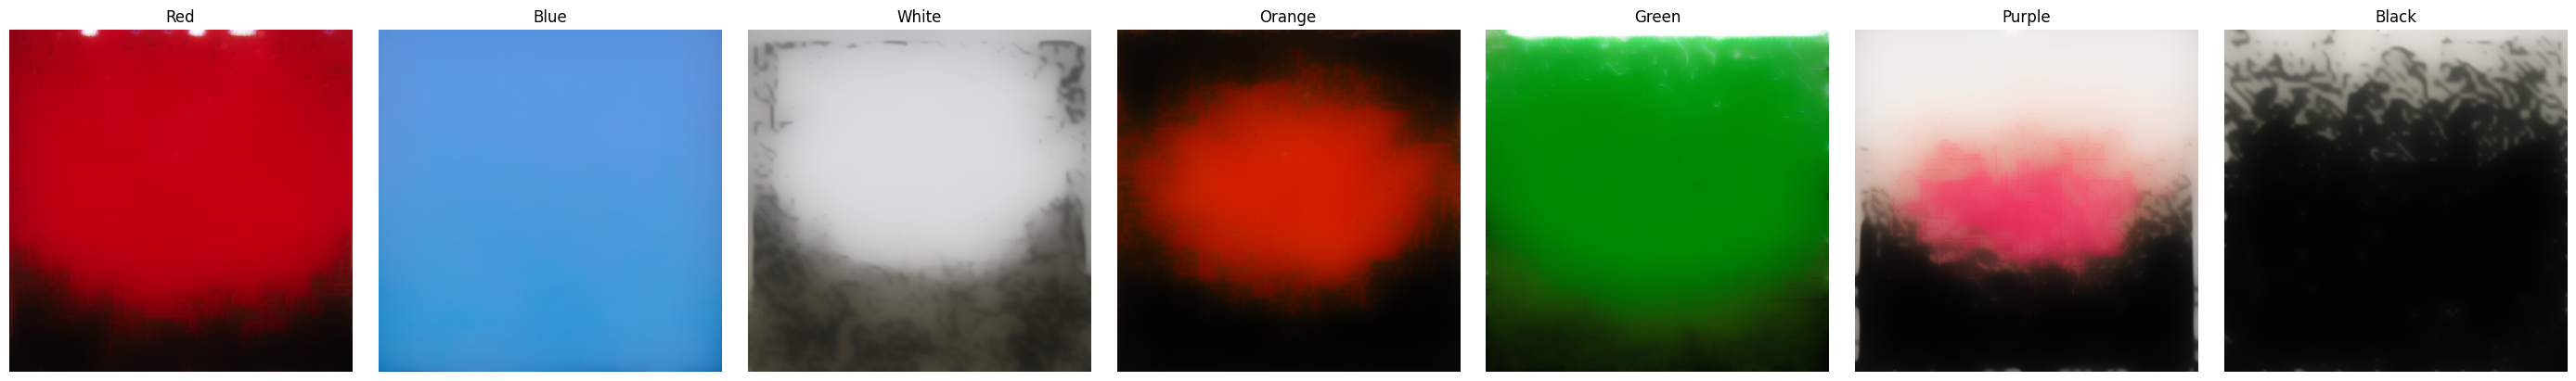

In [18]:
caption = ["Red", "Blue", "White", "Orange", "Green", "Purple", "Black"]
generateImage(caption, modelA, modelB)

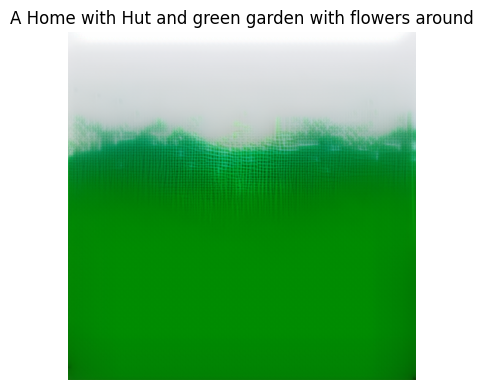

In [19]:
caption = ["A Home with Hut and green garden with flowers around"]
generateImage(caption, modelA, modelB, "home")